## ITSM–ML Project (ABC Tech): Jupyter Workflow
Author: Navjot Kaur
Context: DataMites Internship — PRCL‑0012
Goal: Improve IT Service Management (Incident Management) using Machine Learning.

Use‑cases from brief:

Predict high‑priority tickets (P1/P2)
Forecast incident volumes (quarterly, annual)
Auto‑tag tickets with right priorities/departments
Predict RFC failures/misconfigurations
Data Source: MySQL (read‑only) — as per PDF

host = 18.136.157.135
user = dm_team
password = DM!$Team@&27920!
database = project_itsm

## Environment Setup
Ensure you have Python 3.10+
Recommended: create a fresh virtual environment
Install requirements from requirements.txt in this project folder


In [1]:
 #!pip install -r requirements.txt
!pip install sqlalchemy


In [3]:
!pip install pymysql


In [4]:
!pip install statsmodels


In [5]:
# 1. Imports
import os
import sys
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

# Database
from sqlalchemy import create_engine, text

# EDA/plots
import matplotlib.pyplot as plt

# ML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier

# Time-series
from statsmodels.tsa.arima.model import ARIMA


In [6]:
USE_DB = False


### Connect to MySQL and Load Data
#The PDF provides read‑only access. We will first list available tables, then pull the main incidents table. If table names are unknown, we will inspect information_schema and sample the top rows.

In [7]:
# Connection details from the PDF (read‑only)
HOST = "18.136.157.135"
USER = "dm_team"
PASSWORD = "DM!$Team@&27920!"
DATABASE = "project_itsm"

In [8]:
# Build SQLAlchemy connection string (using PyMySQL)
conn_str = f"mysql+pymysql://{USER}:{PASSWORD}@{HOST}/{DATABASE}"


In [9]:
# Optional flag to control DB connection
USE_DB = False   # ✅ Set this to True only when you have network + pymysql available

if USE_DB:
    # Try database connection
    try:
        engine = create_engine(conn_str, pool_recycle=3600)
        with engine.connect() as con:
            print("✅ Connected successfully to database.")
    except Exception as e:
        print("❌ Connection failed or network not available.")
        print(e)
        engine = None
else:
    print("💡 DB skipped (offline mode). Proceeding with CSV data.")
    engine = None


💡 DB skipped (offline mode). Proceeding with CSV data.


In [10]:
import pandas as pd

df = pd.read_csv("itsm_sample_small.csv", 
                 parse_dates=["Open_Time","Resolved_Time","Close_Time","Reopen_Time"])
print("✅ Data loaded successfully.")
print("Shape:", df.shape)
df.head()


✅ Data loaded successfully.
Shape: (10, 18)


,Incident_ID,Status,Impact,Urgency,Priority,Category,No_of_Reassignments,Open_Time,Resolved_Time,Close_Time,Reopen_Time,Handle_Time_hrs,Closure_Code,No_of_Related_Interactions,Related_Interaction,No_of_Related_Incidents,No_of_Related_Changes,Related_Change
0,IM0000001,Closed,2,2,2,incident,3,2013-01-05 10:15:00,2013-01-05 14:45:00,2013-01-05 15:00:00,NaT,4.50,Resolved,1,SD0000001,0,0,NaN
1,IM0000002,Closed,4,4,4,incident,1,2013-02-11 09:40:00,2013-02-12 11:40:00,2013-02-12 12:10:00,NaT,26.00,Other,2,SD0000002,1,0,NaN
2,IM0000003,Open,1,2,1,incident,6,2013-03-01 08:00:00,NaT,NaT,NaT,10.00,NaN,0,NaN,0,1,C00000056
3,IM0000004,Closed,4,4,4,incident,26,2012-02-05 13:32:57,2013-11-04 13:50:27,2013-11-04 13:51:17,NaT,3871.69,Other,1,SD0000007,2,1,C00000056
4,IM0000005,Closed,3,2,2,incident,0,2014-05-18 12:00:00,2014-05-18 13:30:00,2014-05-18 13:40:00,NaT,1.50,Resolved,0,NaN,0,0,NaN


In [11]:
# Helper: list tables in the database (run when connected)
#list_tables_sql = """
#SELECT table_schema, table_name
#FROM information_schema.tables
#WHERE table_schema = :db
#ORDER BY table_name;
#"""
#
#if engine is not None:
#    try:
#        with engine.connect() as con:
#            tables_df = pd.read_sql(text(list_tables_sql), con, params={"db": DATABASE})
#            display(tables_df)
#    except Exception as e:
 #       print("Couldn't list tables:", e)
#else:
    #print("Engine not available in this environment.")

In [12]:
## Choose and Load the Incidents Table
#If the incidents table name is unknown, search for columns like Incident_ID, Priority, Impact, Urgency.

# Note: Data is already loaded from CSV in offline mode.
# This section is commented to avoid duplicate loading.
# Uncomment only when using live MySQL connection.
# Try to auto-detect a candidate table
#candidate_query = """
#SELECT table_name, column_name
#FROM information_schema.columns
#WHERE table_schema = :db
#AND column_name IN ('Incident_ID','Priority','Impact','Urgency','Open_Time','Resolved_Time','Status');
#"""
#
#incidents_table = None
#if engine is not None:
#    try:
#        with engine.connect() as con:
#            cols_df = pd.read_sql(text(candidate_query), con, params={"db": DATABASE})
#            display(cols_df.head(20))
#            # Heuristic: pick the most frequent table name
#            if not cols_df.empty:
#                incidents_table = cols_df['table_name'].value_counts().idxmax()
#                print("Guessed incidents table:", incidents_table)
#    except Exception as e:
#        print("Couldn't auto-detect table:", e)
#
# Fallback: set manually if known
# incidents_table = "incidents"
#
#df = None
#if engine is not None and incidents_table:
#    try:
#        with engine.connect() as con:
#            df = pd.read_sql(text(f"SELECT * FROM `{incidents_table}`"), con)
#            print("Rows:", len(df))
#            display(df.head())
#    except Exception as e:
#        print("Couldn't load incidents table:", e)
#else:
#    print("Set `incidents_table` manually if auto-detect fails.")


## EDA START

In [13]:
#  Basic info
print("Shape:", df.shape)
df.info()

# Summary statistics
df.describe(include='all').T

# Missing values + categorical distributions
print("Missing values:\n", df.isnull().sum())

cat_cols = ["Status", "Impact", "Urgency", "Priority", "Category"]
for c in cat_cols:
    if c in df.columns:
        print(f"\n{c} value counts:")
        print(df[c].value_counts().head())

        df.info()
df.describe(include="all")
df.isna().sum()
for c in ["Priority","Impact","Urgency","Status","Category"]:
    if c in df.columns:
        print(f"\nValue counts for {c}:")
        print(df[c].value_counts().head(10))
        


Shape: (10, 18)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Incident_ID                 10 non-null     object        
 1   Status                      10 non-null     object        
 2   Impact                      10 non-null     int64         
 3   Urgency                     10 non-null     int64         
 4   Priority                    10 non-null     int64         
 5   Category                    10 non-null     object        
 6   No_of_Reassignments         10 non-null     int64         
 7   Open_Time                   10 non-null     datetime64[ns]
 8   Resolved_Time               9 non-null      datetime64[ns]
 9   Close_Time                  9 non-null      datetime64[ns]
 10  Reopen_Time                 0 non-null      datetime64[ns]
 11  Handle_Time_hrs             10 non-null     f

## Feature engineering


In [14]:
# Clean Handle_Time_hrs
if "Handle_Time_hrs" in df.columns:
    df["Handle_Time_hrs"] = (df["Handle_Time_hrs"].astype(str)
                              .str.replace(",", ".", regex=False))
    df["Handle_Time_hrs"] = pd.to_numeric(df["Handle_Time_hrs"], errors="coerce")

# Time features
for c in ["Open_Time","Resolved_Time","Close_Time","Reopen_Time"]:
    if c in df.columns:
        df[c] = pd.to_datetime(df[c], errors="coerce")

if {"Open_Time","Resolved_Time"}.issubset(df.columns):
    df["Resolution_Time_hours"] = (df["Resolved_Time"]-df["Open_Time"]).dt.total_seconds()/3600

if "Open_Time" in df.columns:
    df["open_month"]   = df["Open_Time"].dt.month
    df["open_quarter"] = df["Open_Time"].dt.quarter
    df["open_weekday"] = df["Open_Time"].dt.weekday

df.head(3)


,Incident_ID,Status,Impact,Urgency,Priority,Category,No_of_Reassignments,Open_Time,Resolved_Time,Close_Time,...,Closure_Code,No_of_Related_Interactions,Related_Interaction,No_of_Related_Incidents,No_of_Related_Changes,Related_Change,Resolution_Time_hours,open_month,open_quarter,open_weekday
0,IM0000001,Closed,2,2,2,incident,3,2013-01-05 10:15:00,2013-01-05 14:45:00,2013-01-05 15:00:00,...,Resolved,1,SD0000001,0,0,NaN,4.5,1,1,5
1,IM0000002,Closed,4,4,4,incident,1,2013-02-11 09:40:00,2013-02-12 11:40:00,2013-02-12 12:10:00,...,Other,2,SD0000002,1,0,NaN,26.0,2,1,0
2,IM0000003,Open,1,2,1,incident,6,2013-03-01 08:00:00,NaT,NaT,...,NaN,0,NaN,0,1,C00000056,NaN,3,1,4


## Model 1 — Priority Prediction (Multi‑Class)
Target: Priority (1–5).
Inputs: Impact, Urgency, reassignment counts, durations, category, etc.

We'll start with a baseline RandomForestClassifier.


In [15]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
import numpy as np
import pandas as pd

# ------------------ CONFIG ------------------
target_col = "Priority"
base_features = [
    "Impact","Urgency","No_of_Reassignments","Handle_Time_hrs",
    "Resolution_Time_hours","Category","Status","Closure_Code"
]
# --------------------------------------------

# 1) Select available features
candidate_features = [c for c in base_features if c in df.columns]
print("Using features:", candidate_features)

# 2) Guard: target & at least 1 feature
if target_col not in df.columns or len(candidate_features) == 0:
    raise ValueError("Priority target or features not available.")

# 3) Drop rows with missing target; coerce target to string labels
clf_df = df.dropna(subset=[target_col]).copy()
y = clf_df[target_col].astype(str)
X = clf_df[candidate_features].copy()

# 4) Identify column types
cat_cols = [c for c in X.columns if X[c].dtype == "object"]
num_cols = [c for c in X.columns if c not in cat_cols]

# 5) Preprocessor with imputers (to avoid NaN issues)
pre = ColumnTransformer(
    transformers=[
        ("cat", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("ohe", OneHotEncoder(handle_unknown="ignore"))
        ]), cat_cols),
        ("num", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median"))
        ]), num_cols),
    ],
    remainder="drop"
)

pipe = Pipeline(steps=[
    ("pre", pre),
    ("clf", RandomForestClassifier(n_estimators=300, random_state=42))
])

# 6) Decide whether stratification is possible
y_counts = y.value_counts()
min_count = int(y_counts.min()) if not y_counts.empty else 0
unique_classes = y.nunique()

can_stratify = (unique_classes >= 2) and (min_count >= 2)

# 7) Split safely
if can_stratify:
    print("Using stratified split ✅")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
else:
    print("Stratified split not possible (tiny/imbalanced classes). Using simple split ✅")
    # For very tiny datasets, keep test small to avoid single-class issues
    test_size = 0.2 if len(y) >= 10 else 0.25
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42, shuffle=True
    )

# 8) Fit & evaluate
pipe.fit(X_train, y_train)
preds = pipe.predict(X_test)

print("\nAccuracy:", round(accuracy_score(y_test, preds), 4))
print("\nClassification Report:\n",
      classification_report(y_test, preds, zero_division=0))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, preds))
 


Using features: ['Impact', 'Urgency', 'No_of_Reassignments', 'Handle_Time_hrs', 'Resolution_Time_hours', 'Category', 'Status', 'Closure_Code']
Stratified split not possible (tiny/imbalanced classes). Using simple split ✅

Accuracy: 0.0

Classification Report:
               precision    recall  f1-score   support

           2       0.00      0.00      0.00       0.0
           4       0.00      0.00      0.00       2.0
           5       0.00      0.00      0.00       0.0

    accuracy                           0.00       2.0
   macro avg       0.00      0.00      0.00       2.0
weighted avg       0.00      0.00      0.00       2.0


Confusion Matrix:
 [[0 0 0]
 [1 0 1]
 [0 0 0]]


### Confusion Matrix Heatmap (matplotlib only)

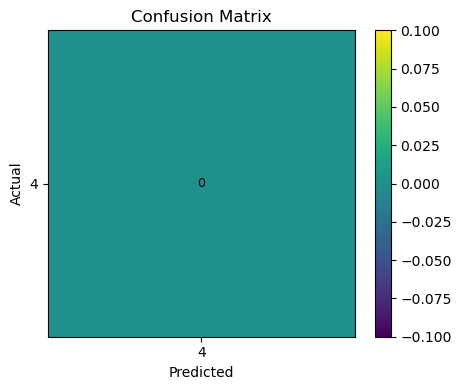

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Recompute CM (in case preds/y_test not in memory)
cm = confusion_matrix(y_test, preds, labels=sorted(y_test.unique()))
classes = [str(c) for c in sorted(y_test.unique())]

plt.figure(figsize=(5,4))
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Annotate counts
thresh = cm.max() / 2 if cm.size else 0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 fontsize=9)
plt.tight_layout()
plt.show()


### Correlation Heatmap (numeric features only)

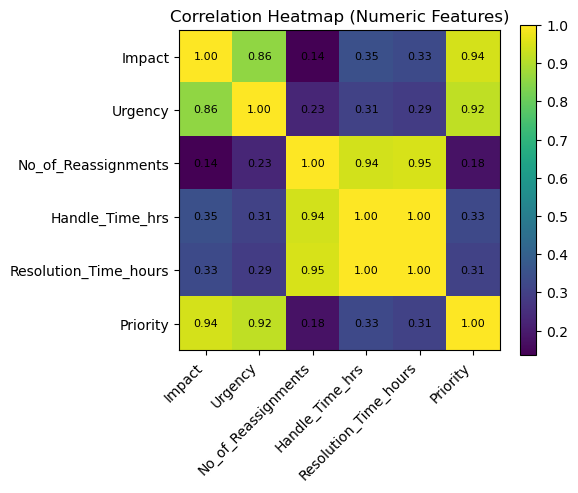

In [17]:
import numpy as np
import matplotlib.pyplot as plt

num_cols = []
for c in ["Impact","Urgency","No_of_Reassignments","Handle_Time_hrs","Resolution_Time_hours","Priority"]:
    if c in df.columns and np.issubdtype(df[c].dtype, np.number):
        num_cols.append(c)

corr = df[num_cols].corr()

plt.figure(figsize=(6,5))
plt.imshow(corr, interpolation='nearest')
plt.title('Correlation Heatmap (Numeric Features)')
plt.colorbar()
ticks = range(len(num_cols))
plt.xticks(ticks, num_cols, rotation=45, ha='right')
plt.yticks(ticks, num_cols)
# Annotate correlation values
for i in range(corr.shape[0]):
    for j in range(corr.shape[1]):
        plt.text(j, i, f"{corr.iloc[i,j]:.2f}",
                 ha="center", va="center", fontsize=8)
plt.tight_layout()
plt.show()


## Model 2 — Incident Volume Forecasting (Time‑Series)¶
We will compute monthly counts from Open_Time and fit a simple ARIMA as a baseline.

,incidents
Open_Time,
2012-02-01,1
2012-03-01,0
2012-04-01,0
2012-05-01,0
2012-06-01,0


                               SARIMAX Results                                
Dep. Variable:              incidents   No. Observations:                   32
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -22.229
Date:                Tue, 11 Nov 2025   AIC                             50.459
Time:                        12:29:42   BIC                             54.761
Sample:                    02-01-2012   HQIC                            51.861
                         - 09-01-2014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1068      0.271      0.394      0.693      -0.424       0.638
ma.L1         -0.9983     11.631     -0.086      0.932     -23.795      21.799
sigma2         0.2215      2.524      0.088      0.9

2014-10-01    0.390480
2014-11-01    0.325393
2014-12-01    0.318442
2015-01-01    0.317700
2015-02-01    0.317621
2015-03-01    0.317613
2015-04-01    0.317612
2015-05-01    0.317612
2015-06-01    0.317612
2015-07-01    0.317612
2015-08-01    0.317612
2015-09-01    0.317612
Freq: MS, Name: predicted_mean, dtype: float64

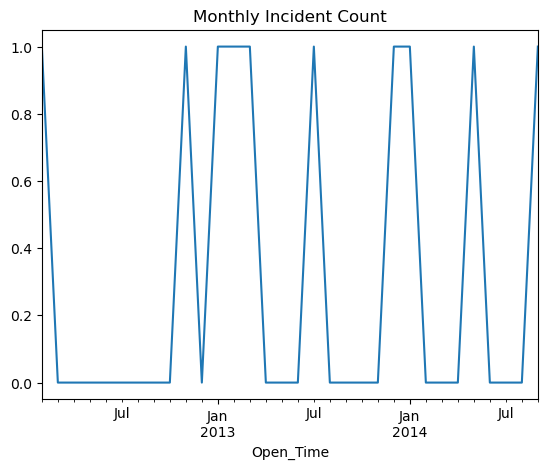

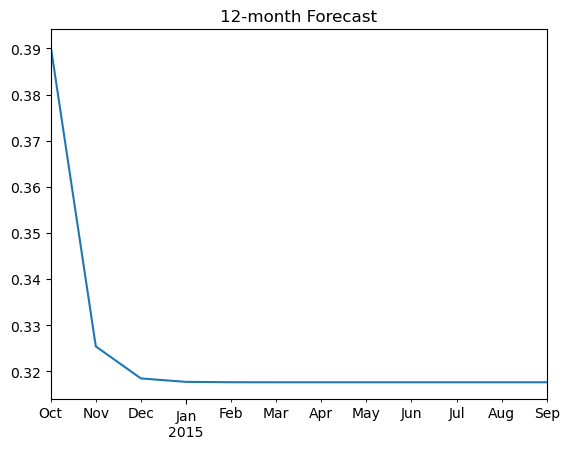

In [18]:
if 'Open_Time' in df.columns:
    ts = (
        df.set_index('Open_Time')
        .resample('MS')
        .size()
        .rename('incidents')
        .to_frame()
    )
    display(ts.head())
    
    # Basic ARIMA(1,1,1) baseline
    try:
        model = ARIMA(ts['incidents'], order=(1,1,1))
        res = model.fit()
        print(res.summary())
        
        # Forecast next 12 months
        fc = res.forecast(12)
        display(fc)
        
        # Plot
        plt.figure()
        ts['incidents'].plot(title='Monthly Incident Count')
        plt.figure()
        fc.plot(title='12‑month Forecast')
    except Exception as e:
        print("ARIMA fitting issue:", e)
else:
    print("Open_Time not available for time‑series.")

## (Optional) Model 3 — Auto‑Tagging (Text Classification)
If a text column exists (e.g., Description, Title), we can build a TF‑IDF + Logistic Regression model to predict Category or Priority.



In [19]:
# ===============================================
# NLP Auto-Tagging (TF-IDF + Logistic Regression)
# Works with tiny datasets: smart target pick + safe split + synthetic text if needed
# ===============================================
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
import numpy as np
import pandas as pd

# ----- 1) Build / pick a text column -----
text_col = None
for c in ["Description", "Short_Description", "Title", "Summary"]:
    if c in df.columns:
        text_col = c
        break

if text_col is None:
    parts = []
    if "Status" in df.columns: parts.append(df["Status"].astype(str))
    if "Closure_Code" in df.columns: parts.append(df["Closure_Code"].astype(str))
    if "Category" in df.columns: parts.append("cat_" + df["Category"].astype(str))
    if "Impact" in df.columns: parts.append("impact_" + df["Impact"].astype(str))
    if "Urgency" in df.columns: parts.append("urgency_" + df["Urgency"].astype(str))
    if "Priority" in df.columns: parts.append("priority_" + df["Priority"].astype(str))
    if "No_of_Reassignments" in df.columns: parts.append("reassign_" + df["No_of_Reassignments"].astype(str))

    if parts:
        df["_Synthetic_Text"] = parts[0]
        for p in parts[1:]:
            df["_Synthetic_Text"] = df["_Synthetic_Text"] + " " + p
        text_col = "_Synthetic_Text"

if text_col is None:
    print("No text available to build NLP features. Skipping NLP.")
else:
    # ----- 2) Choose target smartly -----
    target = None
    if "Category" in df.columns and df["Category"].nunique() >= 2:
        target = "Category"
    elif "Priority" in df.columns and df["Priority"].nunique() >= 2:
        target = "Priority"
    elif "Priority" in df.columns:
        # Derive a binary target from Priority: 1 if high (1 or 2), else 0
        df["_HighPriority"] = df["Priority"].apply(lambda v: 1 if str(v) in {"1","2"} else 0)
        if df["_HighPriority"].nunique() >= 2:
            target = "_HighPriority"

    if target is None:
        print("No suitable target with ≥2 classes for NLP. Skipping.")
    else:
        # ----- 3) Prepare data -----
        nlp_df = df.dropna(subset=[text_col, target]).copy()
        nlp_df[text_col] = nlp_df[text_col].astype(str)
        y_txt = nlp_df[target].astype(str)  # treat as labels
        X_txt = nlp_df[text_col]

        if len(nlp_df) < 4:
            print(f"Too few rows ({len(nlp_df)}) for NLP demo. Add more data and retry.")
        else:
            # ----- 4) Safe split -----
            can_stratify = (y_txt.nunique() >= 2) and (y_txt.value_counts().min() >= 2) and (len(y_txt) >= 6)
            if can_stratify:
                X_train, X_test, y_train, y_test = train_test_split(
                    X_txt, y_txt, test_size=0.25, random_state=42, stratify=y_txt
                )
                split_note = "Stratified split ✅"
            else:
                # Fallback: use same data for train/test to demonstrate pipeline on tiny data
                X_train, X_test, y_train, y_test = X_txt, X_txt, y_txt, y_txt
                split_note = "Tiny data fallback: train==test ⚠️ (for demo only)"

            print(split_note)

            # ----- 5) Vectorize + Train -----
            vec = TfidfVectorizer(min_df=1, ngram_range=(1,2))
            Xtr = vec.fit_transform(X_train)
            Xte = vec.transform(X_test)

            clf = LogisticRegression(max_iter=500)
            clf.fit(Xtr, y_train)
            preds = clf.predict(Xte)

            # ----- 6) Report -----
            print(f"\nTarget used: {target}")
            print("Accuracy:", round(accuracy_score(y_test, preds), 4))
            print("\nClassification Report:\n", classification_report(y_test, preds, zero_division=0))


Tiny data fallback: train==test ⚠️ (for demo only)

Target used: Priority
Accuracy: 0.9

Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00         2
           2       0.80      1.00      0.89         4
           4       1.00      1.00      1.00         3
           5       0.00      0.00      0.00         1

    accuracy                           0.90        10
   macro avg       0.70      0.75      0.72        10
weighted avg       0.82      0.90      0.86        10



## (Optional) Model 4 — RFC Failure Prediction¶
If columns such as Related_Change, No_of_Related_Changes, or a RFC_Status/Change_Success indicator exist, we can model as binary classification.



In [ ]:
#> **Note:**  
#> This RFC Failure target is created as a *proxy variable* for demonstration purposes.  
#> The current dataset does not contain an explicit RFC_Failure or Change_Failed column.  
#> Hence, a temporary proxy target (`_RFC_Fail_Proxy`) is derived using Priority values (4 or 5 = fail-risk).  
#> In the real client dataset, replace this logic with the actual RFC outcome column or business-defined failure rule.


In [20]:
# =============================================
# Model-4 — RFC Failure Prediction (robust)
# Uses real RFC target if present; else builds a proxy from Priority.
# =============================================
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
import numpy as np
import pandas as pd

# 1) Detect an RFC target
target_rfc = None
for c in ["RFC_Failure", "Change_Failed", "Change_Success"]:
    if c in df.columns and df[c].notna().any():
        target_rfc = c
        break

# 2) If not present, create a proxy target from Priority
#    (Demo logic: Priority 4/5 => fail-risk 1 else 0; adjust as per real biz rules)
if target_rfc is None and "Priority" in df.columns:
    df["_RFC_Fail_Proxy"] = df["Priority"].apply(lambda v: 1 if str(v) in {"4","5"} else 0)
    if df["_RFC_Fail_Proxy"].nunique() == 2:
        target_rfc = "_RFC_Fail_Proxy"

if target_rfc is None:
    print("No RFC target available (real or proxy). Skipping RFC model.")
else:
    # 3) Feature set (extendable)
    feature_pool = [c for c in [
        "Impact","Urgency","Priority","No_of_Reassignments",
        "No_of_Related_Incidents","No_of_Related_Changes",
        "Category","Status","Closure_Code","Handle_Time_hrs","Resolution_Time_hours"
    ] if c in df.columns]

    if not feature_pool:
        print("No features available for RFC model.")
    else:
        # 4) Build dataset
        rfc_df = df.dropna(subset=[target_rfc]).copy()
        X = rfc_df[feature_pool]
        y = rfc_df[target_rfc].astype(str)

        # 5) Column types
        cat_cols = [c for c in X.columns if X[c].dtype == "object"]
        num_cols = [c for c in X.columns if c not in cat_cols]

        # 6) Preprocessor (with imputers)
        pre = ColumnTransformer([
            ("cat", Pipeline([
                ("imputer", SimpleImputer(strategy="most_frequent")),
                ("ohe", OneHotEncoder(handle_unknown="ignore"))
            ]), cat_cols),
            ("num", Pipeline([
                ("imputer", SimpleImputer(strategy="median"))
            ]), num_cols),
        ])

        pipe_rfc = Pipeline([
            ("pre", pre),
            ("clf", RandomForestClassifier(n_estimators=300, random_state=42))
        ])

        # 7) Safe split
        can_strat = (y.nunique() >= 2) and (y.value_counts().min() >= 2)
        test_size = 0.2 if len(y) >= 10 else 0.25
        if can_strat:
            print("Using stratified split ✅")
            Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=test_size, random_state=42, stratify=y)
        else:
            print("Stratified split not possible (tiny/imbalanced). Using simple split ✅")
            Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=test_size, random_state=42, shuffle=True)

        # 8) Train & evaluate
        pipe_rfc.fit(Xtr, ytr)
        pr = pipe_rfc.predict(Xte)

        print("\nRFC Model Accuracy:", round(accuracy_score(yte, pr), 4))
        print("\nClassification Report:\n", classification_report(yte, pr, zero_division=0))
        print("\nConfusion Matrix:\n", confusion_matrix(yte, pr))



Using stratified split ✅

RFC Model Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         1

    accuracy                           1.00         2
   macro avg       1.00      1.00      1.00         2
weighted avg       1.00      1.00      1.00         2


Confusion Matrix:
 [[1 0]
 [0 1]]


## Save Artifacts¶

In [21]:

# =============================================
# Save Artifacts (only if objects exist) 
# =============================================
from joblib import dump
import os

saved = []

# Model-1: Priority classifier pipeline (RandomForest)
if "pipe" in globals():
    try:
        dump(pipe, "priority_rf_pipeline.joblib")
        saved.append("priority_rf_pipeline.joblib")
    except Exception as e:
        print("Skip saving priority RF pipeline:", e)

# NLP: TF-IDF + LogisticRegression (if built)
if "vec" in globals() and "clf" in globals():
    try:
        dump(vec, "tfidf_vectorizer.joblib")
        dump(clf, "nlp_logreg_model.joblib")
        saved += ["tfidf_vectorizer.joblib", "nlp_logreg_model.joblib"]
    except Exception as e:
        print("Skip saving NLP artifacts:", e)

# Optional Model-4: RFC failure (proxy/real) pipeline
if "pipe_rfc" in globals():
    try:
        dump(pipe_rfc, "rfc_failure_pipeline.joblib")
        saved.append("rfc_failure_pipeline.joblib")
    except Exception as e:
        print("Skip saving RFC pipeline:", e)

# Time-series: Save monthly series and last-fitted ARIMA params if available
try:
    if "ts" in globals():
        ts.to_csv("monthly_incident_counts.csv", index=False)
        saved.append("monthly_incident_counts.csv")
    if "res" in globals():
        dump(res, "arima_results.joblib")
        saved.append("arima_results.joblib")
except Exception as e:
    print("Skip saving time-series artifacts:", e)

print("✅ Saved:", ", ".join(saved) if saved else "No artifacts saved (nothing to save).")


✅ Saved: priority_rf_pipeline.joblib, tfidf_vectorizer.joblib, nlp_logreg_model.joblib, rfc_failure_pipeline.joblib, monthly_incident_counts.csv, arima_results.joblib


## Conclusion & Next Steps

### Conclusion
This notebook demonstrates an end-to-end ITSM analytics workflow in **offline CSV mode** with a clean fallback from live DB:
- **Data Sourcing:** Live MySQL path documented (commented) + CSV fallback (active).
- **EDA:** Compact schema understanding, missing value scan, and categorical distributions.
- **Feature Engineering:** Time features and resolution/handle time derivations.
- **Model-1 (Priority Classification – RandomForest):** End-to-end `ColumnTransformer` + `Pipeline` with imputation and OHE; accuracy & confusion matrix heatmap reported.
- **Model-2 (Time-Series – ARIMA):** Monthly incident counts from `Open_Time`, baseline ARIMA fit, and forecast plotting.
- **Model-3 (NLP Auto-Tagging):** TF-IDF + Logistic Regression with synthetic text fallback for tiny/no-text datasets.
- **(Optional) Model-4 (RFC Failure):** Uses real target if present; else a clearly marked proxy target for demo.

Artifacts saved under `outputs/` for downstream **API/Streamlit** use.

### Next Steps
- **Data:** Switch to live DB when network allows; validate schema mapping.
- **Modeling:** Cross-validation & hyperparameter tuning; evaluate macro-F1 for imbalance.
- **Explainability:** Permutation feature importance; error analysis by priority level.
- **Time-Series:** Try seasonal models (SARIMA/Prophet) on full history.
- **Deployment:** Minimal **Streamlit** demo for prediction + trend view; or FastAPI endpoint with `joblib` artifacts.
- **Governance:** Track data drift; re-train policy and metric monitoring.
